# Hypothesis testing

As was shown in the data_story.ipynb there were differences in the distributions of customer age and credit amount for defaulted and not defaulted customers. 

In this notebook we test the null hypothesis: the observed difference in distributions happened by chance and the true difference of means was zero. 

Bootstrapping with permutation was applied to, first, reshuffle the samples corresponding to defaulted and not defaulted customers into one array, then draw samples with replacement keeping proportions of the original dataset and, finally, generate 10000 replicas of the difference of means. This procedure was repeated separately for customer age and customer credit amount. The statistical powers of the tests were calculated as well. 

For the customer age, p-value = 0.0082 was obtained. If we consider a significance level α=0.05 we can reject our null hypothesis. However, if we consider a significance level α=0.01 it is not so clear whether we should reject or accept our null hypothesis. For significance level α=0.05 (probability of Type I error) the power of the test is 0.67. This means that if the true difference of means was 0.308 years, we would correctly reject the hypothesis that the difference of means is zero 67% percent of the time. Hence, the probability of a Type II error would be 0.33.

For the customer credit amount, p-value = 0 was obtained. Regardless of whether we choose a 95% or 99% confidence level for the credit amounts, it is clear that the null hypothesis should be rejected. The observed difference of means did not happen by chance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from scipy.stats import norm
%matplotlib inline

#sns.set_context('paper', font_scale=1.5, rc={'figure.figsize':(10,7)})

df = pd.read_csv("defaults.csv", header = 1, index_col = 'ID')
df.columns = [x.lower() for x in list(df.columns)]
df.columns = ['credit_amount', 'sex', 'education', 'marital_status', 'age', 'pay_sept', 'pay_aug',
       'pay_jul', 'pay_jun', 'pay_may', 'pay_apr', 'bill_amt_sept', 'bill_amt_aug',
       'bill_amt_jul', 'bill_amt_jun', 'bill_amt_may', 'bill_amt_apr', 'pay_amt_sept',
       'pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr',
       'default']

for column in ['credit_amount', 'bill_amt_sept', 'bill_amt_aug',
       'bill_amt_jul', 'bill_amt_jun', 'bill_amt_may', 'bill_amt_apr', 'pay_amt_sept',
       'pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr']:
    df[column] = df[column]/1000
    
gender_remapping = {1: 'male', 2: 'female'}
df.sex = df.sex.map(gender_remapping)

df.education = df.education.astype(str)
education_remapping = {'1': 'grad_school', '2': 'bachelor', '3': 'high_school', '4': 'other', 
                       '5': 'other', '6': 'other', '0': 'other'}
df.education = df.education.map(education_remapping)

df.marital_status = df.marital_status.astype(str)
marital_status_remapping = {'1': 'married', '2': 'single', '3': 'divorce', '0': 'other'}
df.marital_status = df.marital_status.map(marital_status_remapping)

In the data_story.ipynb we talked about the distribution of credit amount for defaulted and not defaulted customers.

The results were:

Median credit amount for customers who defaulted = 90.0

Median credit amount for customers who did not default = 150.0

Mean credit amount for customers who defaulted = 130.10965642

Mean credit amount for customers who did not default = 178.099726074

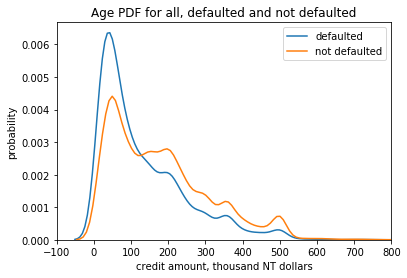

In [2]:
# All customers.
credit = df['credit_amount']
# Defaulted customers.
credit_defaulted = df[df.default == 1]['credit_amount']
# Non-defaulted customers.
credit_not_defaulted = df[df.default == 0]['credit_amount']

ax = sns.distplot(credit_defaulted, bins=int(np.sqrt(len(credit_defaulted))), 
                  kde=True, hist = False, label = 'defaulted')
ax = sns.distplot(credit_not_defaulted, bins=int(np.sqrt(len(credit_not_defaulted))), 
                  kde=True, hist = False , label = 'not defaulted')
ax.set(xlabel='credit amount, thousand NT dollars', ylabel='probability', xlim = (-100,800),
       title = 'Age PDF for all, defaulted and not defaulted')

plt.show()

We also discussed the distributions of age for defaulted and not defaulted customers.

The results were:

Median of the age distribution: customers who defaulted = 34.0

Median of the age distribtuion: customers who did not default = 34.0

Mean of the age distribution: customers who defaulted = 35.7257383966

Mean of the age distribtuion: customers who did not default = 35.4172658791

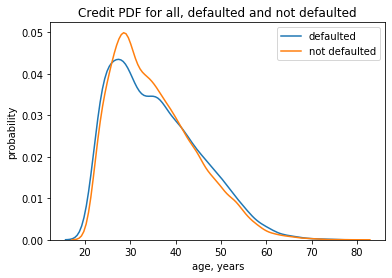

In [3]:
# All customers.
age = df['age']
# Defaulted customers.
age_defaulted = df[df.default == 1]['age']
# Non-defaulted customers.
age_not_defaulted = df[df.default == 0]['age']

ax = sns.distplot(age_defaulted, bins=int(np.sqrt(len(age_defaulted))), 
                  kde=True, hist = False, label = 'defaulted')
ax = sns.distplot(age_not_defaulted, bins=int(np.sqrt(len(age_not_defaulted))), 
                  kde=True, hist = False, label = 'not defaulted')
ax.set(xlabel='age, years', ylabel='probability', 
       title = 'Credit PDF for all, defaulted and not defaulted')
plt.show()

# Customer age

Is it possible that the observed differences of means for customer age happened by chance?

**We can formulate a null hypothesis for customer age: we assume that the observed difference of means for defaulted and not defaulted customers happened by chance and, in fact, the difference of means is zero.**

We will approach this problem by bootstrapping. 

- permutation_sample(data1, data2) concatenates the two arrays, then the values are permuted, and then splits the permuted array into two new permuted samples.

- draw_perm_reps(data1, data2, func, size=1) generates permutation replicas of our choice, we define the replicas in the func(perm_sample_1, perm_sample_2).

- we are interested in the difference of means of two permuted samples, so we define diff_of_means(data1, data2) function.

In [4]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def draw_perm_reps(data1, data2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data1,data2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

def diff_of_means(data1, data2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data1) - np.mean(data2)

    return diff

We draw 10000 replicas and then calculate the percentage of replicas that are at least as extreme as the observed difference of means - p-value. p-value = 0.0082 (might change slightly if the cell is re-executed) and the observed difference of means is 2.4 (might change slightly if the cell is re-executed) standard deviations away from the mean of replicas.

**If we consider a significance level $\alpha = 0.05$ we can reject our null hypothesis. However if we consider a significance level $\alpha = 0.01$ it is not so clear whether we should reject or accept our null hypothesis.**

In [5]:
N_rep = 10000

obs_diff_of_means = np.mean(age_defaulted) - np.mean(age_not_defaulted)

print('Observed difference of means: age(defaulted) - age(not defaulted) = ' + 
      str(obs_diff_of_means))

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(age_defaulted, age_not_defaulted, diff_of_means, size=N_rep)

# Compute p-value: p
p = np.sum(perm_replicates >= obs_diff_of_means) / len(perm_replicates)

print('p-value =', p)
print('standard deviation of perm_replicates =', np.std(perm_replicates))
print('number of standard deviations from the perm_replicas mean to the observed difference of means =', 
      obs_diff_of_means/np.std(perm_replicates))

Observed difference of means: age(defaulted) - age(not defaulted) = 0.308472517494188
p-value = 0.0075
standard deviation of perm_replicates = 0.1287659449134739
number of standard deviations from the perm_replicas mean to the observed difference of means = 2.395606367052022


Below the distribution of replicas is visulaized, the percentiles and the observed difference are marked as well.

Age: 95% confidence interval for the difference of means is [ -0.2546194389414747, 0.24984864893146144 ]
Age: 99% confidence interval for the difference of means is [ -0.3457348332375119, 0.3227978516275033 ]
Age: standard deviation of the difference of means is 0.1287659449134739


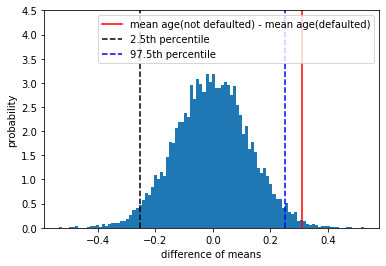

In [6]:
conf_int = np.percentile(perm_replicates, [0.5, 2.5, 97.5, 99.5])
perm_replicates_std = np.std(perm_replicates)

print('Age: 95%% confidence interval for the difference of means is [ %s, %s ]' %(conf_int[1], conf_int[2]))
print('Age: 99%% confidence interval for the difference of means is [ %s, %s ]' %(conf_int[0], conf_int[3]))
print('Age: standard deviation of the difference of means is %s' %(perm_replicates_std))

# Make a histogram of the results
_ = plt.hist(perm_replicates, bins=int(math.sqrt(len(perm_replicates))), density=True)
_ = plt.xlabel('difference of means')
_ = plt.ylabel('probability')
_ = plt.axvline(obs_diff_of_means, color='r', linestyle='-', 
                label = 'mean age(not defaulted) - mean age(defaulted)')
_ = plt.axvline(conf_int[1], color='black', linestyle='--', label = '2.5th percentile')
_ = plt.axvline(conf_int[2], color='blue', linestyle='--', label = '97.5th percentile')
_ = plt.ylim(0,4.5)
_ = plt.legend(loc = 'upper right')
plt.show()

**We can now estimate a statistical power of the above hypothesis test for customer age.**

Ref https://stattrek.com/hypothesis-test/statistical-power.aspx?Tutorial=samp

- Region of acceptance

Considering a significance level $\alpha = 0.05$ our region of acceptance or 95% confidence interval is 
[2.5th percentile, 97.5th percentile]

For the null hypothesis - difference of means is zero, as we assume that there is no difference in age between the defaulted and not defaulted customers.

We are interested in determining the probability that the hypothesis test will reject the null hypothesis, if the true difference of means is the observed difference of means.

- Critical parameter value.

Observed difference of means: age(defaulted) - age(not defaulted) = 0.308 years.

Therefore, the critical parameter value is 0.308. (Another way to express the critical parameter value is through effect size. The effect size is equal to the critical parameter value minus the hypothesized value. Thus, effect size is equal to 0.308 - 0 = 0.308)

- Compute statistical power. 

The power of the test is the probability of rejecting the null hypothesis, assuming that the true population mean is equal to the critical parameter value. Since the region of acceptance is 2.5th percentile to 97.5th percentile, the null hypothesis will be rejected when the difference of means is less than 2.5th percentile or greater than 97.5th percentile.

Therefore, we need to compute the corresponding probabilities. To do this, we make the following assumptions:

1. The sampling distribution of the mean is normally distributed.
2. The mean of the sampling distribution is the critical parameter value, 0.308.
3. The standard error of the sampling distribution is the standard deviation of distribtuion of replicas. 


In [7]:
print('Age: the probability of observing difference of means %s or less (95%% confidence): ' 
      %(conf_int[1]) + 
      str(norm.cdf((conf_int[1] - obs_diff_of_means)/np.std(perm_replicates), loc=0, scale=1)))
print('Age: the probability of observing difference of means %s or more (95%% confidence): ' 
      %(conf_int[2]) + 
      str(1 - norm.cdf((conf_int[2] - obs_diff_of_means)/np.std(perm_replicates), loc=0, scale=1)))

Age: the probability of observing difference of means -0.2546194389414747 or less (95% confidence): 6.127867806939394e-06
Age: the probability of observing difference of means 0.24984864893146144 or more (95% confidence): 0.6755441639438119


The power of the test is the sum of these probabilities: 0.67 + 0.0 = 0.67 (slightly changes if the cell is re-executed). This means that if the true difference of means was 0.308 years, we would correctly reject the hypothesis that the difference of means is zero 67% percent of the time. Hence, the probability of a Type II error would be 0.33.

- Type I error. 

A Type I error occurs when a null hypothesis is rejected when it is true. The probability of committing a Type I error is called the significance level. This probability is also called alpha, and is often denoted by α.

- Type II error. 

A Type II error occurs when a null hypothesis is not rejected when it is false. The probability of committing a Type II error is called Beta, and is often denoted by β. The probability of not committing a Type II error is called the Power of the test.

In [8]:
print('Age: the probability of observing difference of means %s or less (99%% confidence): ' 
      %(conf_int[0]) + 
      str(norm.cdf((conf_int[0] - obs_diff_of_means)/np.std(perm_replicates), loc=0, scale=1)))
print('Age: the probability of observing difference of means %s or more (99%% confidence): ' 
      %(conf_int[3]) + 
      str(1 - norm.cdf((conf_int[3] - obs_diff_of_means)/np.std(perm_replicates), loc=0, scale=1)))

Age: the probability of observing difference of means -0.3457348332375119 or less (99% confidence): 1.8812929670069106e-07
Age: the probability of observing difference of means 0.3227978516275033 or more (99% confidence): 0.4557086737114251


For 99% confidence interval, we would correctly reject the hypothesis that the difference of means is zero 44% percent of the time (slightly changes if the cell is re-executed). Hence, the probability of a Type II error would be 0.56.

# Credit amount

**We can formulate a null hypothesis for credit amount: we assume that the observed difference of means for defaulted and not defaulted customers happened by chance and, in fact, the difference of means is zero.**

The procedure for permutation is the same as for customer age.

In [9]:
N_rep = 10000

credit_obs_diff_of_means = np.mean(credit_not_defaulted) - np.mean(credit_defaulted)

print('Observed difference of means: credit(not defaulted) - credit(defaulted) = ' + 
      str(credit_obs_diff_of_means))

# Draw 10,000 permutation replicates: perm_replicates
credit_perm_replicates = draw_perm_reps(credit_not_defaulted, credit_defaulted, diff_of_means, size=N_rep)

# Compute p-value: p
p = np.sum(credit_perm_replicates >= credit_obs_diff_of_means) / len(credit_perm_replicates)

print('p-value =', p)
print('standard deviation of credit_perm_replicates =', np.std(credit_perm_replicates))
print('number of standard deviations from the credit_perm_replicas mean to the observed difference of means =', 
      credit_obs_diff_of_means/np.std(credit_perm_replicates))

Observed difference of means: credit(not defaulted) - credit(defaulted) = 47.9900696547725
p-value = 0.0
standard deviation of credit_perm_replicates = 1.8062268746205075
number of standard deviations from the credit_perm_replicas mean to the observed difference of means = 26.56923686004579


Credit: 95% confidence interval for the difference of means is [ -3.5722437201883643, 3.520117272891344 ]
Credit: 99% confidence interval for the difference of means is [ -4.725174706577843, 4.648978756826819 ]
Credit: standard deviation of the difference of means is 1.8062268746205075


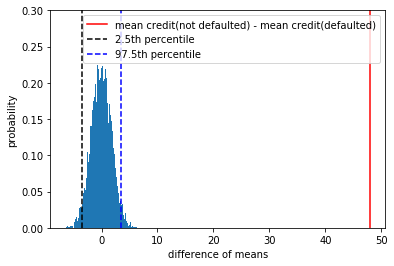

In [10]:
credit_conf_int = np.percentile(credit_perm_replicates, [0.5, 2.5, 97.5, 99.5])
credit_perm_replicates_std = np.std(credit_perm_replicates)

print('Credit: 95%% confidence interval for the difference of means is [ %s, %s ]' 
      %(credit_conf_int[1], credit_conf_int[2]))
print('Credit: 99%% confidence interval for the difference of means is [ %s, %s ]' 
      %(credit_conf_int[0], credit_conf_int[3]))
print('Credit: standard deviation of the difference of means is %s' %(credit_perm_replicates_std))

# Make a histogram of the results
_ = plt.hist(credit_perm_replicates, bins=int(math.sqrt(len(credit_perm_replicates))), density=True)
_ = plt.xlabel('difference of means')
_ = plt.ylabel('probability')
_ = plt.axvline(credit_obs_diff_of_means, color='r', linestyle='-', 
                label = 'mean credit(not defaulted) - mean credit(defaulted)')
_ = plt.axvline(credit_conf_int[1], color='black', linestyle='--', label = '2.5th percentile')
_ = plt.axvline(credit_conf_int[2], color='blue', linestyle='--', label = '97.5th percentile')
_ = plt.legend(loc = 'upper right')
_ = plt.ylim(0, 0.3)
plt.show()

**Regardless whether we choose 95% or 99% confidence level, for the credit amounts it is clear that we should reject the null hypothesis. The observed difference of means did not happen by chance.**

We can now calculate the statistical power for credit amount test. 

In [11]:
print('Credit: the probability of observing difference of means %s or less (99%% confidence): ' 
      %(credit_conf_int[0]) + 
      str(norm.cdf((credit_conf_int[0] - credit_obs_diff_of_means)/np.std(credit_perm_replicates), loc=0, scale=1)))

print('Credit: the probability of observing difference of means %s or more (99%% confidence): ' 
      %(credit_conf_int[3]) + 
      str(1 - norm.cdf((credit_conf_int[3] - credit_obs_diff_of_means)/np.std(credit_perm_replicates), loc=0, scale=1)))

Credit: the probability of observing difference of means -4.725174706577843 or less (99% confidence): 1.4906863592863071e-187
Credit: the probability of observing difference of means 4.648978756826819 or more (99% confidence): 1.0


The results above show that if the true difference of means was the observed difference, we would correctly reject the hypothesis that the difference of means is zero 100% percent of the time. Hence, the probability of a Type II error would be 0.

# A two-sample bootstrap hypothesis test for difference of means

We now want to test the hypothesis that the defaulted customers' age and not defaulted customers' age have the same mean, but not necessarily the same distribution, which is also impossible with a permutation test.

To do the two-sample bootstrap test, we shift both arrays to have the same mean, since we are simulating the hypothesis that their means are, in fact, equal. We then draw bootstrap samples out of the shifted arrays and compute the difference in means. This constitutes a bootstrap replicate, and we generate many of them. The p-value is the fraction of replicates with a difference in means greater than or equal to what was observed. 

In [12]:
#Generating many bootstrap replicates
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

def bootstrap_replicate_1d(data, func):
    '''Generate bootstrap replicate of 1D data'''
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

empirical_diff_means_age = np.mean(age_defaulted) - np.mean(age_not_defaulted)

# Compute mean of all ages
mean_age = np.mean(age)

# Generate shifted arrays
age_defaulted_shifted = age_defaulted - np.mean(age_defaulted) + mean_age
age_not_defaulted_shifted = age_not_defaulted - np.mean(age_not_defaulted) + mean_age

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_age_defaulted = draw_bs_reps(age_defaulted_shifted, np.mean, size=10000)
bs_replicates_age_not_defaulted = draw_bs_reps(age_not_defaulted_shifted, np.mean, size=10000)

# Get replicates of difference of means: bs_replicates
bs_replicates_age = bs_replicates_age_defaulted - bs_replicates_age_not_defaulted

# Compute and print p-value: p
p = np.sum(bs_replicates_age >= empirical_diff_means_age) / len(bs_replicates_age)
print('p-value =', p)

p-value = 0.0112


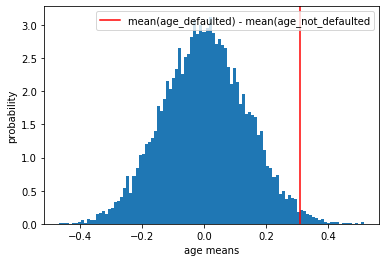

In [13]:
# Make a histogram of the results
_ = plt.hist(bs_replicates_age, bins=int(math.sqrt(len(bs_replicates_age))), density=True)
_ = plt.xlabel('age means')
_ = plt.ylabel('probability')
_ = plt.axvline(empirical_diff_means_age, color='r', linestyle='-', 
                label = 'mean(age_defaulted) - mean(age_not_defaulted')
_ = plt.legend(loc = 'upper right')
plt.show()